#### Note: Using a preexisting LightGBM Model to test for comparing accuracy

## Imports

In [1]:
import pandas as pd
import torch
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import joblib

## Load Data

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path, encoding='utf-16')
    df['text'] = df['text'].fillna('')
    print(df.head())
    print(f"Number of classes: {len(df['label'].unique())}")
    print(f"Number of samples: {len(df)}")
    return df['text'].values, df['label'].values

data_path = '../../data-preprocessing/combined_dataset.csv'
texts, labels = load_data(data_path)


   label                                               text
0      0                      tappanakii with happybirthday
1      0  why you should start paying attention to pro s...
2      0  me before sending a risky text vs me after it ...
3      0                                          capterwin
4      0  lot of blackberry lane winter theme cross stit...
Number of classes: 6
Number of samples: 191970


## Split dataset into train, validation, and test sets

In [3]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=42)

## Histogram of Data Distribution

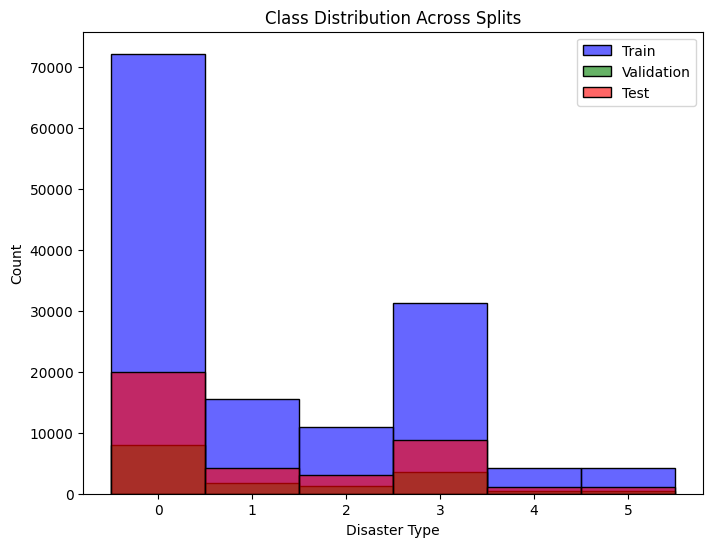

In [4]:
plt.figure(figsize=(8,6))
sns.histplot(train_labels, bins=np.arange(-0.5, 6, 1), kde=False, label='Train', color='blue', alpha=0.6)
sns.histplot(val_labels, bins=np.arange(-0.5, 6, 1), kde=False, label='Validation', color='green', alpha=0.6)
sns.histplot(test_labels, bins=np.arange(-0.5, 6, 1), kde=False, label='Test', color='red', alpha=0.6)
plt.legend()
plt.xlabel('Disaster Type')
plt.ylabel('Count')
plt.title('Class Distribution Across Splits')
plt.show()


## Setup for LightGBM Parameters

In [5]:

# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

y_train = train_labels
y_val = val_labels
y_test = test_labels

# Convert to LightGBM Dataset format
d_train = lgb.Dataset(X_train, label=y_train)
d_val = lgb.Dataset(X_val, label=y_val, reference=d_train)

# Set LightGBM parameters
params = {
    'objective': 'multiclass',
    'num_class': 6,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'device': 'gpu' if torch.cuda.is_available() else 'cpu'
}

## Training

In [6]:
model = lgb.train(params, d_train, valid_sets=[d_train, d_val], num_boost_round=100, callbacks=[lgb.early_stopping(stopping_rounds=10)])

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 253631
[LightGBM] [Info] Number of data points in the train set: 138218, number of used features: 4996
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score -0.650570
[LightGBM] [Info] Start training from score -2.190123
[LightGBM] [Info] Start training from score -2.542458
[LightGBM] [Info] Start training from score -1.485438
[LightGBM] [Info] Start training from score -3.481913
[LightGBM] [Info] Start training from score -3.489234
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.0957516	valid_1's multi_logloss: 0.131642


## Making Predictions

In [7]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)

## Confusion Matrix

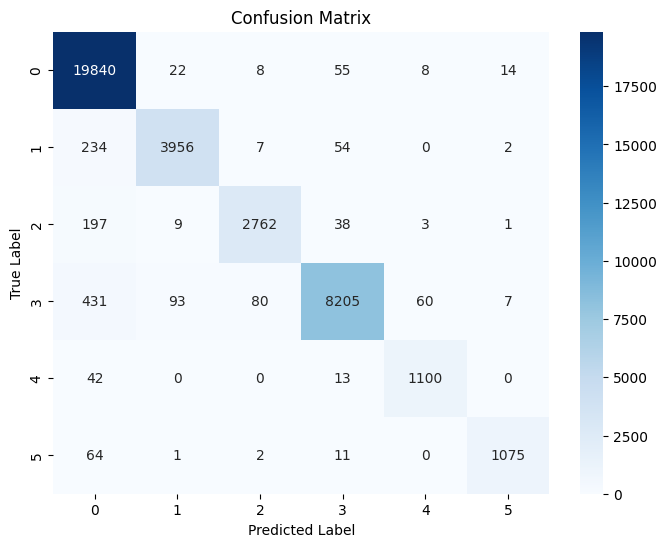

In [8]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Display classification report

In [10]:
disaster_categories = {
    0: "No Disaster",
    1: "Earthquake",
    2: "Flood",
    3: "Hurricane",
    4: "Tornado",
    5: "Wildfire"
}

print("Classification Report:") 
print(classification_report(y_test, y_pred, target_names=disaster_categories.values()))

Classification Report:
              precision    recall  f1-score   support

 No Disaster       0.95      0.99      0.97     19947
  Earthquake       0.97      0.93      0.95      4253
       Flood       0.97      0.92      0.94      3010
   Hurricane       0.98      0.92      0.95      8876
     Tornado       0.94      0.95      0.95      1155
    Wildfire       0.98      0.93      0.95      1153

    accuracy                           0.96     38394
   macro avg       0.96      0.94      0.95     38394
weighted avg       0.96      0.96      0.96     38394



## Save model and vectorizer using JobLib


In [11]:
joblib.dump(model, 'lightgbm_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

# Deployment function (if needed)

In [12]:
def predict_disaster(texts):
    vectorizer = joblib.load('tfidf_vectorizer.pkl')
    model = joblib.load('lightgbm_model.pkl')
    X = vectorizer.transform(texts)
    preds = model.predict(X)
    return np.argmax(preds, axis=1)

# Example usage (random generated tweets)
sample_texts = [
    "Earthquake shakes the city center, causing widespread panic.",
    "Wildfire spreads rapidly, threatening homes and wildlife.",
    "Heavy rain causing severe flooding in downtown area. Roads are impassable!",
    "Tornado spotted near the outskirts of town. Seek shelter immediately!",
    "Hurricane approaching the coast, residents urged to evacuate.",
    "No disaster here, just a beautiful sunny day at the beach.",
    "Flood waters rising quickly, residents advised to move to higher ground.",
    "Wildfire smoke causing poor air quality in the region.",
    "Earthquake aftershocks felt throughout the night.",
    "Tornado warning issued for the county, take cover now!"
]
predictions = predict_disaster(sample_texts)

for text, pred in zip(sample_texts, predictions):
    print(f"Text: {text}\nPredicted Disaster Type: {disaster_categories[pred]}\n")

Text: Earthquake shakes the city center, causing widespread panic.
Predicted Disaster Type: Earthquake

Text: Wildfire spreads rapidly, threatening homes and wildlife.
Predicted Disaster Type: Wildfire

Text: Heavy rain causing severe flooding in downtown area. Roads are impassable!
Predicted Disaster Type: Hurricane

Text: Tornado spotted near the outskirts of town. Seek shelter immediately!
Predicted Disaster Type: Tornado

Text: Hurricane approaching the coast, residents urged to evacuate.
Predicted Disaster Type: Hurricane

Text: No disaster here, just a beautiful sunny day at the beach.
Predicted Disaster Type: No Disaster

Text: Flood waters rising quickly, residents advised to move to higher ground.
Predicted Disaster Type: Flood

Text: Wildfire smoke causing poor air quality in the region.
Predicted Disaster Type: Wildfire

Text: Earthquake aftershocks felt throughout the night.
Predicted Disaster Type: Earthquake

Text: Tornado warning issued for the county, take cover now!
Pr